In [ ]:
# from google.colab import drive
# drive.mount("/content/gdrive")

In [ ]:
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

#Importing test dataset
df_test_FD001 = pd.read_csv('/content/gdrive/My Drive/Capstone/test_FD001.txt', sep=' ', header=None)
df_train_FD001 = pd.read_csv('/content/gdrive/My Drive/Capstone/train_FD001.txt', sep=' ', header=None)


# dropping NAN values
df_test_FD001 = df_test_FD001.dropna(axis=1, how='all')
df_train_FD001 = df_train_FD001.dropna(axis=1, how='all')

# Naming the columns
df_test_FD001.columns = ["unit", "cycles", "Op1",
                      "Op2", "Op3", "S1", "S2",
                      "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11",
                      "S12", "S13", "S14", "S15", "S16", "S17", "S18", "S19", "S20", "S21"]

df_train_FD001.columns = ["unit", "cycles", "Op1",
                      "Op2", "Op3", "S1", "S2",
                      "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11",
                      "S12", "S13", "S14", "S15", "S16", "S17", "S18", "S19", "S20", "S21"]

# data preprocessing; removing unnecessary data
df_test_FD001.drop(['Op3','S1', 'S5', 'S6', 'S16', 'S10', 'S18', 'S19'], axis=1, inplace=True)
df_train_FD001.drop(['Op3','S1', 'S5', 'S6', 'S16', 'S10', 'S18', 'S19'], axis=1, inplace=True)

df_test_FD001['unit'] += 100


In [ ]:
df_combined = pd.concat([df_train_FD001, df_test_FD001]) #combine the two datasets

from sklearn.preprocessing import MinMaxScaler
# MinMaxScaler
scaler = MinMaxScaler()
df_combined.iloc[:,2:18] = scaler.fit_transform(df_combined.iloc[:,2:18])

In [ ]:
#split them again
df_train_FD001 = df_combined[(df_combined.unit <= 100)]
df_test_FD001 = df_combined[(df_combined.unit >= 101)]

df_test_FD001['unit'] -= 100

In [ ]:
# finding the max cycles of a unit which is used to find the Time to Failure (TTF)

df_train_FD001 = pd.merge(df_train_FD001, df_train_FD001.groupby('unit', as_index=False)['cycles'].max(), how='left', on='unit')
df_train_FD001.rename(columns={"cycles_x": "cycles", "cycles_y": "maxcycles"}, inplace=True)

df_train_FD001['TTF'] = df_train_FD001['maxcycles'] - df_train_FD001['cycles']

# defining Fraction of Time to Failure (fTTF), where value of 1 denotes healthy engine and 0 denotes failure
def fractionTTF(dat,q):
    return(dat.TTF[q]-dat.TTF.min()) / (dat.TTF.max()-dat.TTF.min())

fTTFz = []
fTTF = []

for i in range(df_train_FD001['unit'].min(),df_train_FD001['unit'].max()+1):
    dat=df_train_FD001[df_train_FD001.unit==i]
    dat = dat.reset_index(drop=True)
    for q in range(len(dat)):
        fTTFz = fractionTTF(dat, q)
        fTTF.append(fTTFz)

df_train_FD001['fTTF'] = fTTF


In [ ]:
# train set
X_test = df_test_FD001[['cycles', 'Op1', 'Op2', 'S2', 'S3', 'S4', 'S7', 'S8', 'S9', 'S11', 'S12',
          'S13', 'S14', 'S15', 'S17', 'S20', 'S21']].values

# test set
X_train = df_train_FD001[['cycles', 'Op1', 'Op2', 'S2', 'S3', 'S4', 'S7', 'S8', 'S9', 'S11', 'S12',
          'S13', 'S14', 'S15', 'S17', 'S20', 'S21']].values
y_train = df_train_FD001[['fTTF']].values.ravel()

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.wrappers.scikit_learn import KerasRegressor

model = Sequential()
model.add(Dense(50, input_dim=17, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs = 50)

Epoch 1/50
645/645 [==============================] - 1s 920us/step - loss: 0.0232
Epoch 2/50
645/645 [==============================] - 1s 964us/step - loss: 0.0062
Epoch 3/50
645/645 [==============================] - 1s 996us/step - loss: 0.0060
Epoch 4/50
645/645 [==============================] - 1s 951us/step - loss: 0.0056
Epoch 5/50
645/645 [==============================] - 1s 984us/step - loss: 0.0054
Epoch 6/50
645/645 [==============================] - 1s 966us/step - loss: 0.0057
Epoch 7/50
645/645 [==============================] - 1s 993us/step - loss: 0.0053
Epoch 8/50
645/645 [==============================] - 1s 1ms/step - loss: 0.0050
Epoch 9/50
645/645 [==============================] - 1s 973us/step - loss: 0.0050
Epoch 10/50
645/645 [==============================] - 1s 976us/step - loss: 0.0049
Epoch 11/50
645/645 [==============================] - 1s 984us/step - loss: 0.0047
Epoch 12/50
645/645 [==============================] - 1s 952us/step - loss: 0.0049
Epo

In [ ]:
score = model.predict(X_test) 
df_test_FD001['predicted'] = score

# df_test_FD001

In [ ]:
def totcycles(data):
    return(data['cycles'] / (1-data['predicted']))
    
df_test_FD001['maxpredcycles'] = totcycles(df_test_FD001)

# df_test_FD001

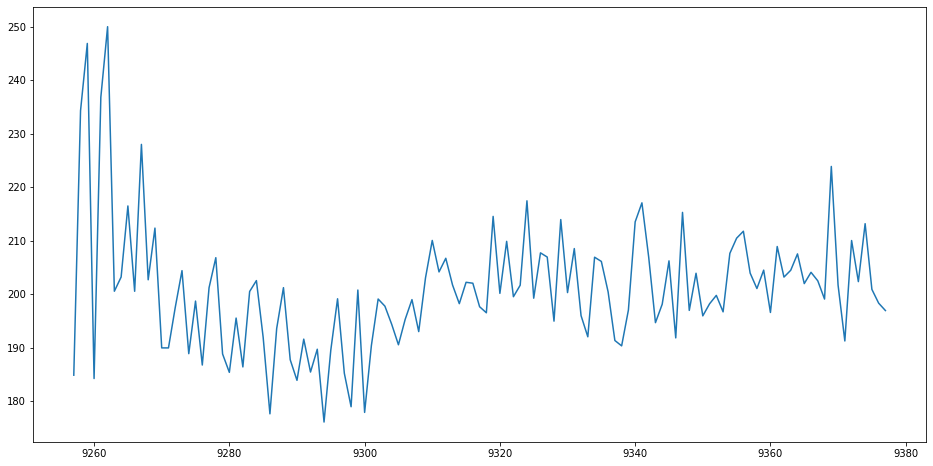

In [ ]:
plt.figure(figsize = (16, 8)) 
plt.plot(df_test_FD001.maxpredcycles[(df_test_FD001['cycles'] >10) & (df_test_FD001['unit']==72)])


In [ ]:
df_test_FD001.maxpredcycles[(df_test_FD001['cycles'] >10) & (df_test_FD001['unit']==80)].mean()

189.90008544921875

In [ ]:
for i in range(df_test_FD001['unit'].min(),df_test_FD001['unit'].max()+1):
   df_test_FD001.maxpredcycles[(df_test_FD001['unit'] == i)] = df_test_FD001.maxpredcycles[(df_test_FD001['cycles'] >10) & (df_test_FD001['unit']==i)].mean()

In [ ]:
df_test_FD001['Pred_RUL'] = df_test_FD001.maxpredcycles * (df_test_FD001['predicted'])

# df_test_FD001

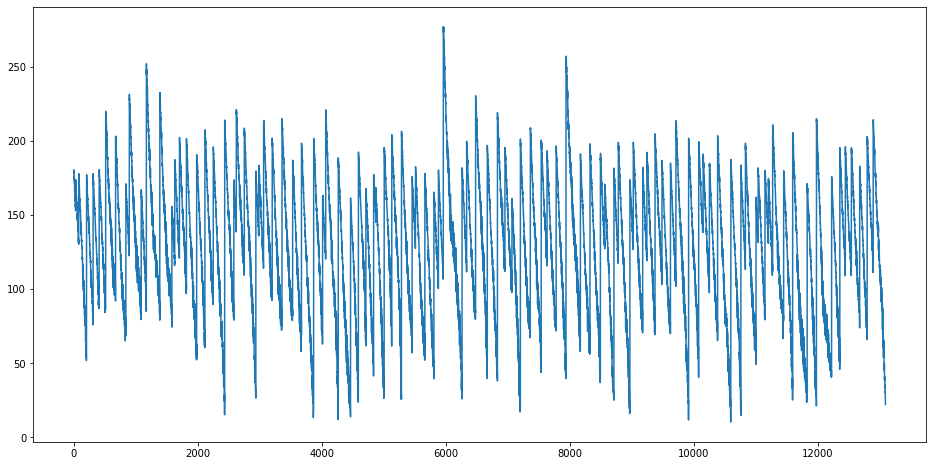

In [ ]:
plt.figure(figsize = (16, 8)) 
plt.plot(df_test_FD001.Pred_RUL)

In [ ]:
df_test_FD001.Pred_RUL[(df_test_FD001['unit']==94)].min()

45.857276916503906

In [ ]:
maxpred = []
for i in range(1,101):
  maxpred.append(df_test_FD001.Pred_RUL[(df_test_FD001['unit']==i)].min()) 

len(maxpred)

100

In [ ]:
Results = pd.read_csv('/content/gdrive/My Drive/Capstone/RUL_FD001.txt', sep=' ', header=None)
Results = Results.dropna(axis=1, how='all')
Results.columns = ["Actual RUL"]

In [ ]:
Results = pd.read_csv('/content/gdrive/My Drive/Capstone/RUL_FD001.txt', sep=' ', header=None)
Results = Results.dropna(axis=1, how='all')
Results.columns = ["Actual RUL"]
Results = Results.assign(unit=[1 + i for i in range(len(Results))])[['unit'] + Results.columns.tolist()]
Results['Pred RUL'] = maxpred
Results['Difference'] = Results['Actual RUL'] - Results['Pred RUL']
Results.set_index('unit')

,Actual RUL,Pred RUL,Difference
unit,,,
1,112,152.780273,-40.780273
2,98,130.159592,-32.159592
3,69,51.824234,17.175766
4,82,75.841064,6.158936
5,91,86.848358,4.151642
...,...,...,...
96,137,109.159767,27.840233
97,82,73.860512,8.139488
98,59,65.947823,-6.947823


In [ ]:
# RMSE
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

RMSE = sqrt(mean_squared_error(Results['Actual RUL'], Results['Pred RUL']))
print("RMSE: ", RMSE)


RMSE:  22.852348683876393
